<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets
### FairFace
- Paper: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf
- GitHub: https://github.com/joojs/fairface?tab=readme-ov-file

### UTKface
- Github: https://susanqq.github.io/UTKFace/

# 0. Packages and functions

In [4]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDriveFile
import os
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.applications import mobilenet_v3
import keras
from keras import layers, models

def create_lists(df):
  import numpy as np
  import pandas as pd
  from PIL import Image
  # Initialize lists to store images and labels
  images = []
  ages = []
  races = []
  genders = []

  # Iterate over each row in the DataFrame
  for _, row in df.iterrows():  # Iterate over each row in the sampled dataframe
    img_path = row['file']           # Extract the file path
    age_code = row['age_code']       # Extract the age code
    race_code = row['race_code']     # Extract the race code
    gender_code = row['gender_code'] # Extract the gender code

    try:
        # Open the image
        img = Image.open(img_path)

        # Convert the image to RGB (if it's grayscale or RGBA)
        img = img.convert("RGB")

        # Resize the image to the target size (224, 224)
        img = img.resize((224, 224))

        # Convert the resized image to a numpy array
        img_array = np.array(img)

        # Ensure the image has the correct shape (224, 224, 3)
        if img_array.shape == (224, 224, 3):
            images.append(img_array)  # Append the image to the list
            ages.append(age_code)  # Append the age code to the 'ages' list
            races.append(race_code)
            genders.append(gender_code)

        else:
            print(f"Skipping image with incorrect shape: {img_path}")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

  # Convert lists to numpy arrays
  images = np.array(images)
  ages = np.array(ages)
  races = np.array(races)
  genders = np.array(genders)

  return images, ages, races, genders

# 1. Loading and preprocessing data FairFace

## Loading

### Loading images

In [6]:
# Step 1: Install PyDrive
!pip install PyDrive

# Step 2: Import the required libraries
import os
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Step 3: Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 4: Specify the file ID from the link
file_id = '1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86'

# Step 5: Download the .zip file
downloaded = drive.CreateFile({'id': file_id})
zip_filename = 'downloaded_file.zip'  # Name of the downloaded zip file
downloaded.GetContentFile(zip_filename)

print(f"{zip_filename} downloaded successfully!")

# Step 6: Create the extracted directory if it doesn't exist
extract_dir = '/content/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 7: Extract the .zip file into the /content/extracted directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to {extract_dir}")

InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

### Loading labels

In [ ]:
# Step 1: Import the necessary libraries if not already imported
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Step 2: Authenticate and create the PyDrive client (if not already done)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 3: Function to download CSV file from Google Drive
def download_csv(file_id, destination):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination)
    print(f"Downloaded file saved as {destination}")

# Step 4: File IDs and destinations for Train and Validation labels
train_file_id = '1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH'  # Train labels file ID
val_file_id = '1wOdja-ezstMEp81tX1a-EYkFebev4h7D'    # Validation labels file ID

train_labels_path = '/content/train_labels.csv'
val_labels_path = '/content/val_labels.csv'

# Step 5: Download Train and Validation label CSV files
download_csv(train_file_id, train_labels_path)
download_csv(val_file_id, val_labels_path)

df_fairface_train = pd.read_csv(train_labels_path)
df_fairface_val = pd.read_csv(val_labels_path)

## Data preprocessing
- Currently uses train and validations set defined from the original paper -> no need to use data_split later

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm  # For the progress bar (if not already installed, run: !pip install tqdm)

tqdm.pandas()

train_df = df_fairface_train.copy()
val_df = df_fairface_val.copy()

# Not sure what service_test is
train_df.drop(columns=['service_test'],inplace=True)
val_df.drop(columns=['service_test'],inplace=True)

# Define the base image directory
base_img = Path('/content/extracted')

# Update labels in both train_df and val_df
train_df['age'] = train_df['age'].replace('more than 70', '70+')
val_df['age'] = val_df['age'].replace('more than 70', '70+')

# Update the 'file' column for train and val dataframes
train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

In [ ]:
###### Mapping gender
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

###### Mapping age
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Setting the desired order
train_df['age'] = train_df['age'].astype('category')
train_df['age'] = train_df['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
train_df['age_code'] = train_df['age'].cat.codes

# Creating the age map
age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])

###### Mapping race
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories,range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x:race_map[x])

In [ ]:
# New desired mapping: White, Black, Asian, Indian, and Others
# Create a function to map the current race categories to the target categories
def map_race_to_target(race):
    if race in ['East Asian', 'Southeast Asian']:
        return 'Asian'
    elif race in ['Latino_Hispanic', 'Middle Eastern']:
        return 'Others'
    else:
        return race  # Retain 'White', 'Black', and 'Indian' as is

# Define the desired category order
desired_order = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Apply the mapping function to map the races to the target categories
train_df['race'] = train_df['race'].map(map_race_to_target)
val_df['race'] = val_df['race'].map(map_race_to_target)

# Convert to categorical type and set the desired category order
train_df['race'] = train_df['race'].astype('category')
train_df['race'] = train_df['race'].cat.set_categories(desired_order, ordered=True)

val_df['race'] = val_df['race'].astype('category')
val_df['race'] = val_df['race'].cat.set_categories(desired_order, ordered=True)

# Create 'race_code' using the ordered categories
train_df['race_code'] = train_df['race'].cat.codes
val_df['race_code'] = val_df['race'].cat.codes

# Create the new race_map based on the new categories
race_map_fair = dict(zip(range(len(desired_order)), desired_order))

# Display the resulting mappings
print("New Race Mapping:", race_map_fair)

In [ ]:
# Assuming train_df and val_df are your dataframes
df_fairface_raw = pd.concat([train_df, val_df], ignore_index=True)
print(len(df_fairface_raw))
df_fairface_raw.head()

In [ ]:
from PIL import Image
import numpy as np

# Lists to store the extracted data
images_fairface = []
ages_fairface = df_fairface_raw['age_code'].tolist()  # List of age codes
genders_fairface = df_fairface_raw['gender_code'].tolist()  # List of gender codes
ethnicities_fairface = df_fairface_raw['race_code'].tolist()  # List of race codes

In [ ]:
df_fairface_eda = df_fairface_raw[['age','gender','race']]
df_fairface_code = df_fairface_raw[['file','age_code','gender_code','race_code']]

### Data test

In [ ]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/train/1.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")

# 2. Loading and preprocessing data UTKface

## Download data

In [11]:
!pip install PyDrive

In [12]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


## Data Preprocessing

### Data test

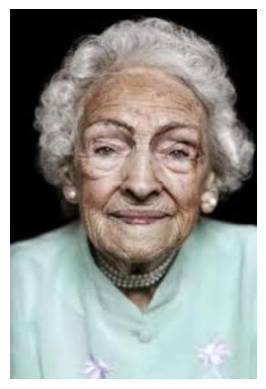

Shape: (551, 368, 3)


In [13]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


### Delete non-images

In [14]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg


### Delete invalid mesasges

In [15]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


### Creating lists for training

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Initialize lists to store images and labels
images = []
ages_utkface = []
genders_utkface = []
ethnicities_utkface = []
files_utkface = []  # New list to store file paths

# Process each directory
for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)  # Create the full file path

        if image is not None:  # Check if the image was loaded successfully
            # Parse filename to extract labels
            split_var = file.split('_')
            ages_utkface.append(int(split_var[0]))
            genders_utkface.append(int(split_var[1]))
            ethnicities_utkface.append(int(split_var[2]))
            files_utkface.append(file_path)  # Store the file path in the list
        else:
            print(f"Failed to load image: {file_path}")

# Create a dataframe from the lists
df_utkface = pd.DataFrame({
    'age': ages_utkface,
    'gender': genders_utkface,
    'ethnicity': ethnicities_utkface,
    'file': files_utkface  # Add the file paths as a column
})

Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [17]:
# Create a DataFrame from the lists
df_utkface_raw = pd.DataFrame({
    'file': files_utkface,
    'age_raw': ages_utkface,
    'gender_code': genders_utkface,
    'race_code': ethnicities_utkface
})

## Mapping

In [18]:
### Mapping age
# Define the age mapping function
def map_age(age):
    if age <= 2:
        return '0-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 19:
        return '10-19'
    elif 20 <= age <= 29:
        return '20-29'
    elif 30 <= age <= 39:
        return '30-39'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    elif 60 <= age <= 69:
        return '60-69'
    else:
        return '70+'

# Map the 'age_raw' column to the 'age' column
df_utkface_raw['age'] = df_utkface_raw['age_raw'].apply(map_age)

# Setting the desired order for 'age'
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_utkface_raw['age'] = df_utkface_raw['age'].astype('category')
df_utkface_raw['age'] = df_utkface_raw['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
df_utkface_raw['age_code'] = df_utkface_raw['age'].cat.codes

In [19]:
# Mapping gender
# Define gender mapping
gender_map = {0: 'Male', 1: 'Female'}

# Map 'gender_code' to the 'gender' column
df_utkface_raw['gender'] = df_utkface_raw['gender_code'].map(gender_map)

# Mapping race
# Define race mapping based on the specified order
race_map_utk = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Map 'race_code' to the 'race' column
df_utkface_raw['race'] = df_utkface_raw['race_code'].map(race_map_utk)

In [20]:
df_utkface_code = df_utkface_raw[['file','age_code','gender_code','race_code']]
df_utkface_eda = df_utkface_raw[['age','gender','race']]

# 3. EDA

## EDA Fairface

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


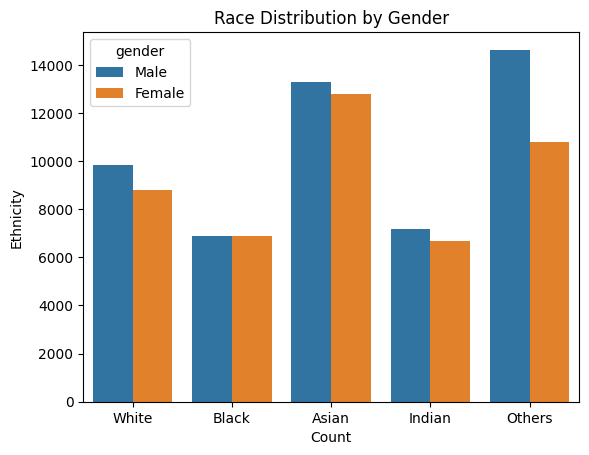

In [21]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_fairface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='gender', ylabel='count'>

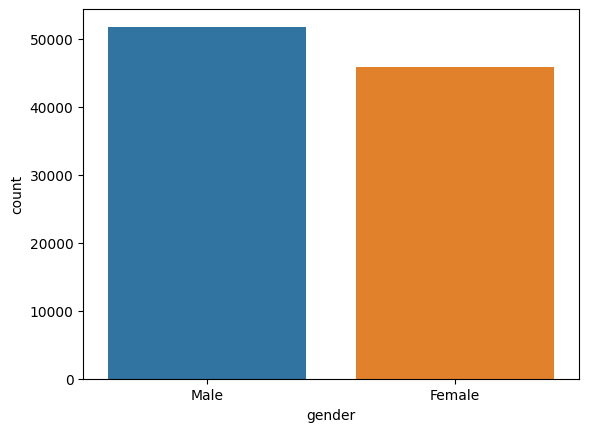

In [22]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_fairface_eda, x ='gender', hue ='gender')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


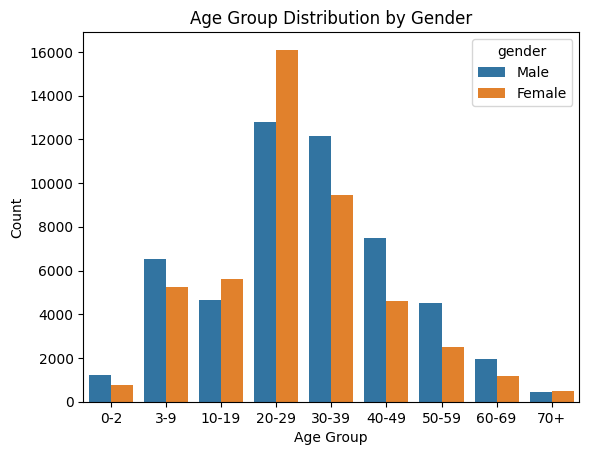

In [23]:
# Ensure the age column in df_fairface_eda has the correct category order using .loc to avoid the warning
df_fairface_eda.loc[:, 'age'] = pd.Categorical(df_fairface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_fairface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

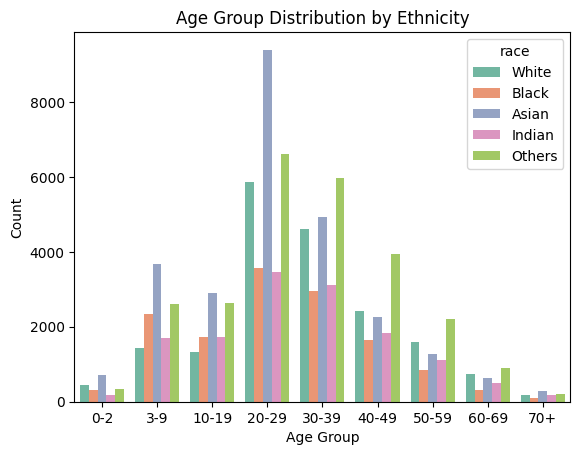

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_fairface_eda, x='age', hue='race', palette='Set2', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## EDA UTKface

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


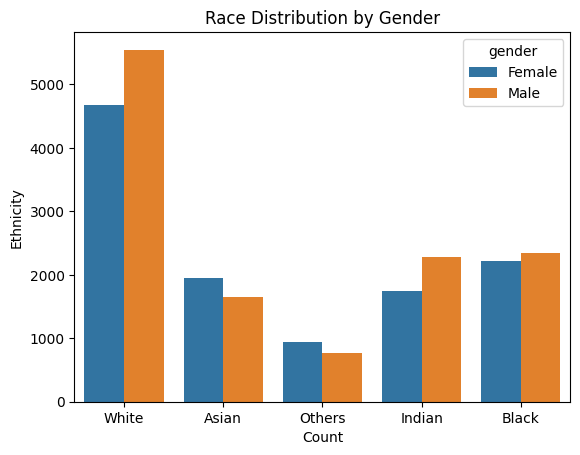

In [25]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_utkface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='gender', ylabel='count'>

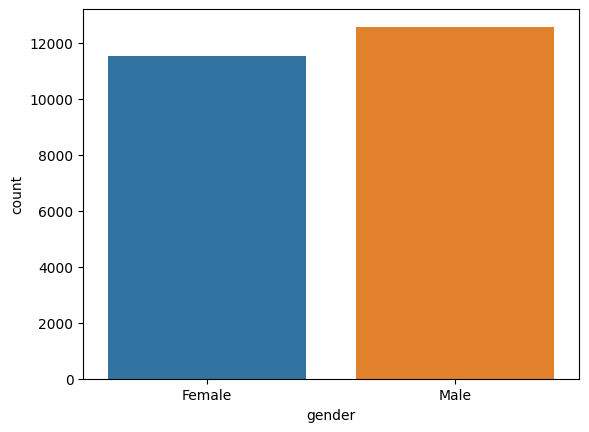

In [26]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_utkface_eda, x ='gender', hue ='gender')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


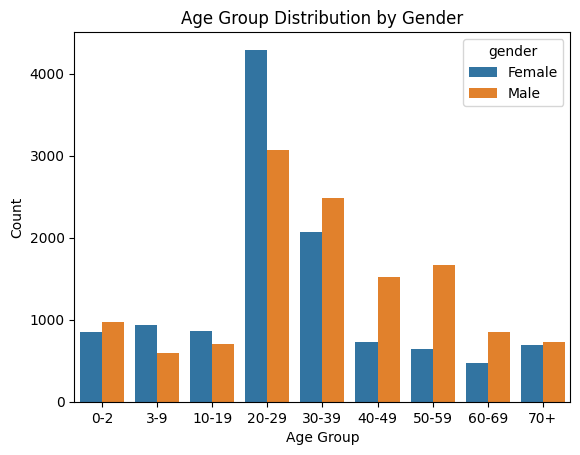

In [27]:
# Ensure the age column in df_utkface_eda has the correct category order using .loc to avoid the warning
df_utkface_eda.loc[:, 'age'] = pd.Categorical(df_utkface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_utkface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

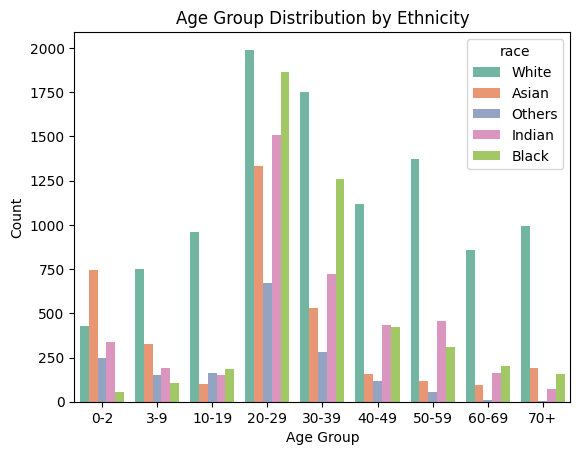

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_utkface_eda, x='age', hue='race', palette='Set2')

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 4. Normalizing age group distribution
## Methods
1. Age groups 0-2 and 3-9 are combined into 0-9
2. Age groups from 50-59, 60-69 and 70+ are combined into 50+
3. Add data from UTKface to: 0-9, 10-19, 40-49, and 50+

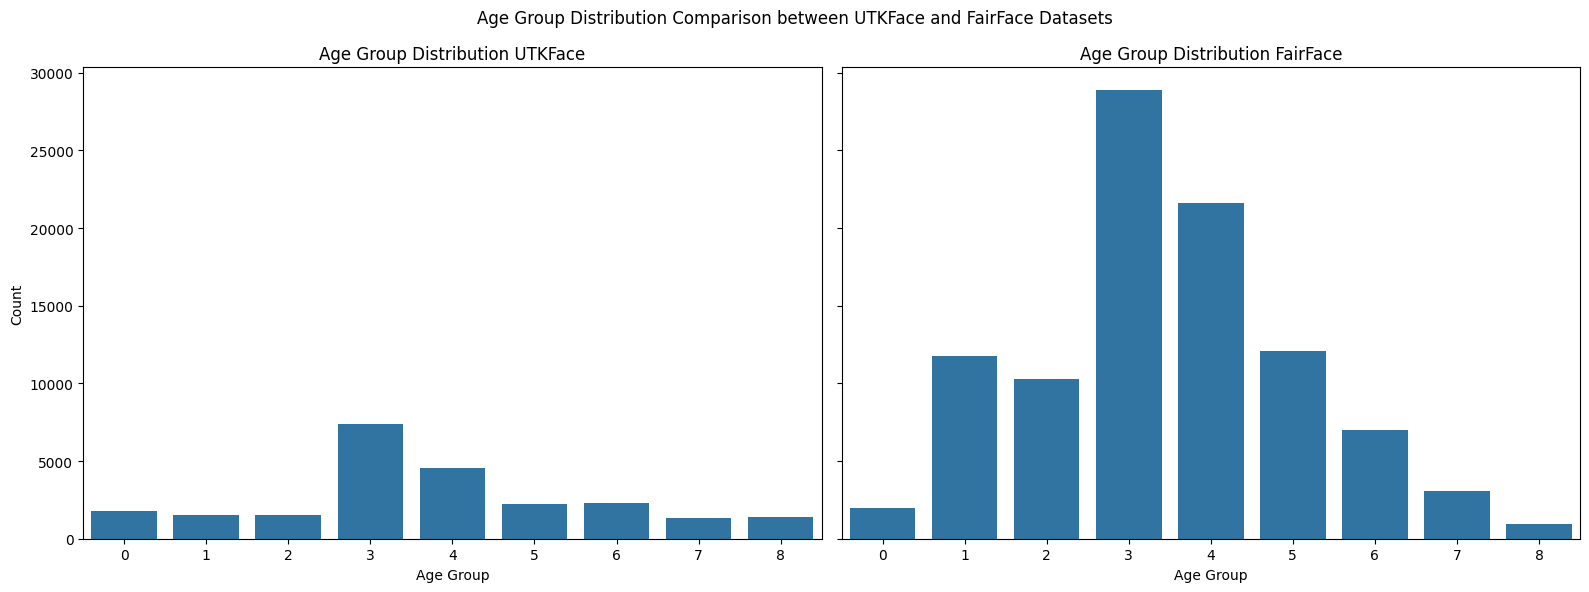

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first distribution for the UTKFace dataset
sns.countplot(data=df_utkface_code, x='age_code', ax=axes[0])
axes[0].set_title('Age Group Distribution UTKFace')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(age_map)))
axes[0].set_xticklabels(age_map.values())

# Plot the second distribution for the FairFace dataset
sns.countplot(data=df_fairface_code, x='age_code', ax=axes[1])
axes[1].set_title('Age Group Distribution FairFace')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(age_map)))
axes[1].set_xticklabels(age_map.values())

# Adjust the layout and show the plots
plt.suptitle('Age Group Distribution Comparison between UTKFace and FairFace Datasets')
plt.tight_layout()
plt.show()

In [30]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 and 1 into group 0
    elif age_code in [6, 7, 8]:
        return 6  # Merge age groups 6, 7, and 8 into group 6
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_fairface = df_fairface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5   # '50+'
}

# Apply the sequential mapping using .loc
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50+'      # Group 5 (previously group 6)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_fairface.loc[:, 'age'] = df_fairface['age_code'].map(age_group_mapping)


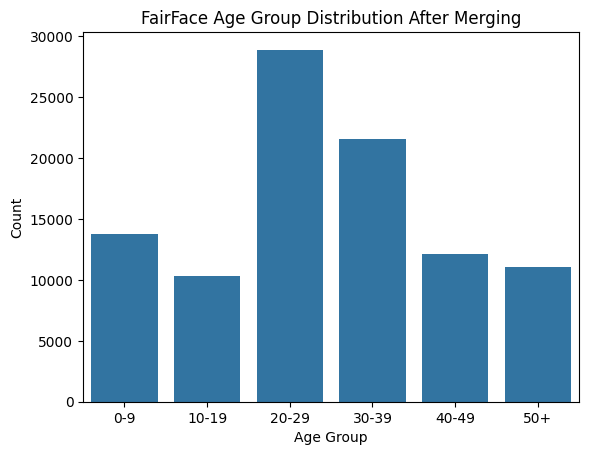

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_fairface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_fairface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('FairFace Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

In [32]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 and 1 into group 0
    elif age_code in [6, 7, 8]:
        return 6  # Merge age groups 6, 7, and 8 into group 6
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_utkface = df_utkface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5   # '50+'
}

# Apply the sequential mapping using .loc
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50+'      # Group 5 (previously group 6)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_utkface.loc[:, 'age'] = df_utkface['age_code'].map(age_group_mapping)

<ipython-input-32-8ad469bbc8ec>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 0 0 ... 5 3 4]' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)


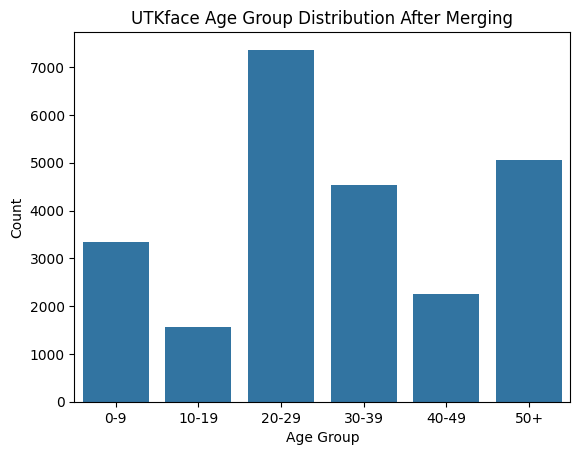

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_utkface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_utkface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('UTKface Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## Concatenating age groups 0, 1, 4, and 5

<ipython-input-34-87410581ae30>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_utkface['dataset'] = 'UTK'


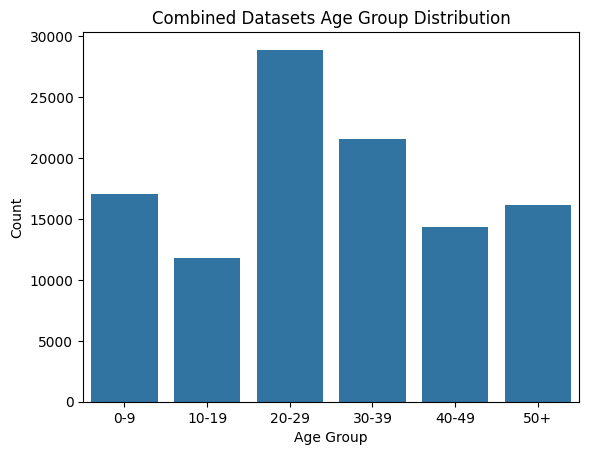

In [34]:
import pandas as pd

# Step 1: Filter `df_utkface` to include only the specified age groups
filtered_utkface = df_utkface[df_utkface['age_code'].isin([0, 1, 4, 5])]

# Add columns indicating if the image is from UTK or FairFace
filtered_utkface['dataset'] = 'UTK'
df_fairface['dataset'] = 'FairFace'

# Step 2: Concatenate the filtered `df_utkface` with `df_fairface`
df = pd.concat([df_fairface, filtered_utkface], ignore_index=True)

# Define the correct order of the age groups based on the mapping
age_order = sorted(df['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('Combined Datasets Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 5. Loading and preprocessing images and ages

Race codes

UTKFace:

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}


FairFace:

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [35]:
df.head()

,file,age_code,gender_code,race_code,age,dataset
0,/content/extracted/train/1.jpg,5,0,2,50+,FairFace
1,/content/extracted/train/2.jpg,3,1,3,30-39,FairFace
2,/content/extracted/train/3.jpg,0,1,1,0-9,FairFace
3,/content/extracted/train/4.jpg,2,1,3,20-29,FairFace
4,/content/extracted/train/5.jpg,2,1,3,20-29,FairFace


In [36]:
# Select only 100,000 random images from the dataframe
sample_df = df.sample(n=100000, random_state=42)  # Set random_state for reproducibility

# Create lists
images, ages, races, genders = create_lists(sample_df)

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))

print(f"Loaded {len(images)} images.")

Loaded 100000 images.


# 6. Baseline MobileNet v3

In [37]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Clean up
del df_fairface_eda, df_fairface_raw, df_utkface_eda, df_utkface_raw, ethnicities_fairface, ethnicities_utk, files_utkface, files, genders_fairface, genders_utkface

NameError: name 'ethnicities_utk' is not defined

## Model setup

In [39]:
# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

# Clean up
del images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w, X_temp, y_temp_age, y_temp_races, y_temp_gender

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    # input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)
12683000/12683000 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...


In [ ]:
inputs = keras.Input(shape=(images[0].shape[0], images[0].shape[1], images[0].shape[2]))
x = mobilenet_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/"
model_name = 'best_mobilenet_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_5  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_10 (Ba  (None, 960)               3840      
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            (None, 1024)              984064    
                                                           

## Model train

In [ ]:
mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
1172/1172 [==============================] - ETA: 0s - loss: 1.4376 - accuracy: 0.4213
Epoch 1: val_accuracy improved from -inf to 0.45880, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/best_mobilenet_model_baseline.keras
1172/1172 [==============================] - 461s 390ms/step - loss: 1.4376 - accuracy: 0.4213 - val_loss: 1.3408 - val_accuracy: 0.4588
Epoch 2/30
1172/1172 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.5349
Epoch 2: val_accuracy did not improve from 0.45880
1172/1172 [==============================] - 447s 382ms/step - loss: 1.1463 - accuracy: 0.5349 - val_loss: 1.3160 - val_accuracy: 0.4529
Epoch 3/30
1172/1172 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.6041
Epoch 3: val_accuracy improved from 0.45880 to 0.46090, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/best_mobilenet_model_baseline.keras
1172/1172 [=============================

KeyboardInterrupt: 

## Model evaluation

In [41]:
def evaluate_and_plot(history):
  import matplotlib.pyplot as plt
  # Get the accuracy and loss data from the history object
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(accuracy) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(X_test, y_test, model):
  from sklearn.metrics import confusion_matrix
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  y_pred = model.predict(X_test)  # x_test is your test data
  y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions
  cm = confusion_matrix(y_test, y_pred) # Calculate confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_group_mapping.values(), yticklabels=age_group_mapping.values())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [42]:
evaluate_and_plot(mobilenet_history)
plot_confusion_matrix(X_test, y_test)

NameError: name 'mobilenet_history' is not defined

## Ekstra with lower learningrate


In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

Training set: (41208, 224, 224, 3), Training labels: (41208,)
Age validation set: (10989, 224, 224, 3), Age validation labels: (10989,)
Age test set: (2748, 224, 224, 3), Age test labels: (2748,)
Race validation labels: (10989,)
Race test labels: (2748,)
Gender validation labels: (10989,)
Gender test labels: (2748,)
12683000/12683000 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...


In [ ]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                             

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project"
model_name = 'best_mobilenet_model_baseline_low.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [ ]:
mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
1288/1288 [==============================] - ETA: 0s - loss: 1.7705 - accuracy: 0.2986
Epoch 1: val_accuracy improved from -inf to 0.37428, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_model_baseline_low.keras
1288/1288 [==============================] - 232s 176ms/step - loss: 1.7705 - accuracy: 0.2986 - val_loss: 1.5879 - val_accuracy: 0.3743
Epoch 2/20
1288/1288 [==============================] - ETA: 0s - loss: 1.5120 - accuracy: 0.3929
Epoch 2: val_accuracy improved from 0.37428 to 0.40413, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_model_baseline_low.keras
1288/1288 [==============================] - 224s 174ms/step - loss: 1.5120 - accuracy: 0.3929 - val_loss: 1.4863 - val_accuracy: 0.4041
Epoch 3/20
1288/1288 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.4236
Epoch 3: val_accuracy improved from 0.40413 to 0.41787, saving model to /content/drive/MyDrive/Visual reg/Projectbest_mobilenet_m

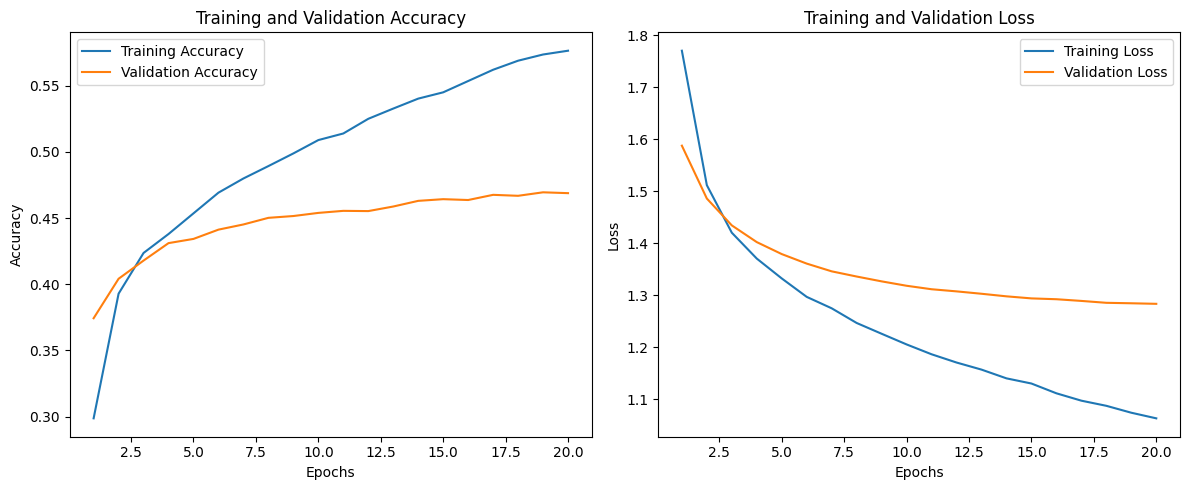

NameError: name 'y_test' is not defined

In [ ]:
evaluate_and_plot(mobilenet_history)
plot_confusion_matrix(X_test, y_test)

# Trying other convolutional bases

In [41]:
# Import a couple of applications
from keras.applications import MobileNetV3Large
from keras.applications import Xception
from keras.applications import ResNet50V2

# Import conv bases
conv_base_Xception = Xception(
    include_top=False,
    weights="imagenet",
)

conv_base_ResNet = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

conv_base_MobileNet = MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
)

def build_model(input_shape, conv_base):
  name = conv_base.name
  inputs = keras.Input(shape=input_shape)
  x = conv_base(inputs)

  if name == 'xception':
    x = keras.applications.xception.preprocess_input(x)

  elif name == 'resnet50v2':
    x = keras.applications.resnet_v2.preprocess_input(x)

  elif name == 'mobilenetv3large':
    x = keras.applications.mobilenet_v3.preprocess_input(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(512, activation = 'relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(256, activation = 'relu')(x)
  outputs = layers.Dense(num_classes_age, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

# Build models
input_shape = images[0].shape
mobilenet = build_model(input_shape, conv_base_MobileNet)
xception = build_model(input_shape, conv_base_Xception)
resnet = build_model(input_shape, conv_base_ResNet)

# Compile models
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

mobilenet.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

xception.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

resnet.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

# Callbacks for each conv base
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_mobilenet = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/mobilenet.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

checkpoint_xception = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/xception.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')


checkpoint_resnet = ModelCheckpoint(
    '/content/drive/MyDrive/Visual reg/Project/resnet.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

94668760/94668760 [==============================] - 0s 0us/step


In [43]:
# Train mobilenet
mobilenet_history = mobilenet.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_mobilenet]
)

evaluate_and_plot(mobilenet_history)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.4724
Epoch 1: val_accuracy improved from -inf to 0.47630, saving model to /content/drive/MyDrive/Visual reg/Project/mobilenet.keras
1172/1172 [==============================] - 761s 649ms/step - loss: 1.2722 - accuracy: 0.4724 - val_loss: 1.2636 - val_accuracy: 0.4763
Epoch 2/10
  26/1172 [..............................] - ETA: 11:26 - loss: 0.9316 - accuracy: 0.6178

KeyboardInterrupt: 

In [44]:
# Train xception
xception_history = xception.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_xception]
)

evaluate_and_plot(xception_history)

Epoch 1/10


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable block1_conv1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [45]:
# Train resnet
resnet_history = resnet.fit(
    X_train,
    y_train_age,
    epochs=310,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint_resnet]
)

evaluate_and_plot(resnet_history)

Epoch 1/310


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable conv1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


## Multitask Learning (experiment)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base_MobileNet.name

'MobilenetV3large'

In [ ]:
# Build model
input_shape = images[0].shape
inputs = keras.Input(shape=input_shape)
x = mobilenet_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x_age = layers.Dense(64)(x)
x_ethnicity = layers.Dense(64)(x)
x_gender = layers.Dense(64)(x)
output_age = layers.Dense(num_classes_age, activation="softmax")(x_age)
output_ethnicity = layers.Dense(num_classes_ethnicity, activation="softmax")(x_ethnicity)
output_gender = layers.Dense(num_classes_gender, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=[output_age, output_ethnicity])
model.summary()

## Learning Rate Decay (experiment)

In [ ]:
# Set custom learning rate
initial_learning_rate = 1e-3  # Adjust as needed
first_decay_steps = 1000

lr_decayed_fn = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
    name="SGDRDecay",
)

optimizer = keras.optimizers.AdamW(learning_rate=lr_decayed_fn)


model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

# Finding a Base

## Resnet

In [46]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the ResNet50V2 preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size (this part stays the same)
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project/"
model_name = 'best_resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)
Conv base, training, and validation sets have been created...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_no

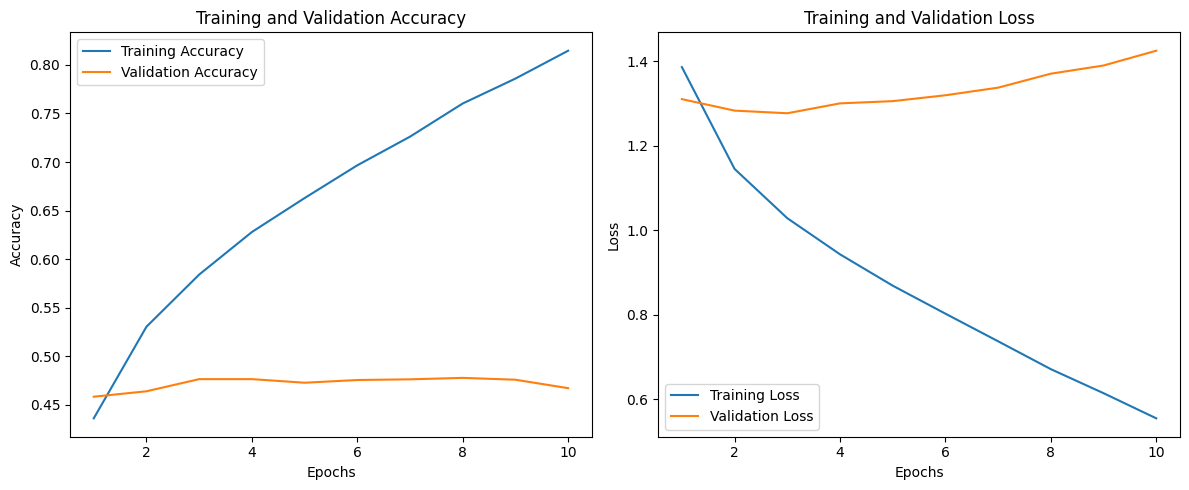

In [47]:
evaluate_and_plot(resnet_history)

## Xception

In [38]:
from keras.applications.xception import preprocess_input  # Update the import for Xception
from keras.applications import Xception  # Import the Xception model
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the Xception preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size (this part stays the same)
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the Xception model using the preprocessed images
conv_base = Xception(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using Xception as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



Training set: (37500, 224, 224, 3), Training labels: (37500,)
Age validation set: (10000, 224, 224, 3), Age validation labels: (10000,)
Age test set: (2500, 224, 224, 3), Age test labels: (2500,)
Race validation labels: (10000,)
Race test labels: (2500,)
Gender validation labels: (10000,)
Gender test labels: (2500,)
83683744/83683744 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
            

In [39]:
# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project/"
model_name = 'best_xception_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
xception_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

evaluate_and_plot(xception_history)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 1.4461 - accuracy: 0.4200
Epoch 1: val_accuracy improved from -inf to 0.44210, saving model to /content/drive/MyDrive/Visual reg/Project/best_xception_model_baseline.keras
1172/1172 [==============================] - 701s 595ms/step - loss: 1.4461 - accuracy: 0.4200 - val_loss: 1.3590 - val_accuracy: 0.4421
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.4984
Epoch 2: val_accuracy improved from 0.44210 to 0.46070, saving model to /content/drive/MyDrive/Visual reg/Project/best_xception_model_baseline.keras
1172/1172 [==============================] - 684s 584ms/step - loss: 1.2221 - accuracy: 0.4984 - val_loss: 1.3349 - val_accuracy: 0.4607
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.5477
Epoch 3: val_accuracy did not improve from 0.46070
1172/1172 [==============================] - 681s 582ms/step - loss: 1.1191 - accuracy

NameError: name 'evaluate_and_plot' is not defined

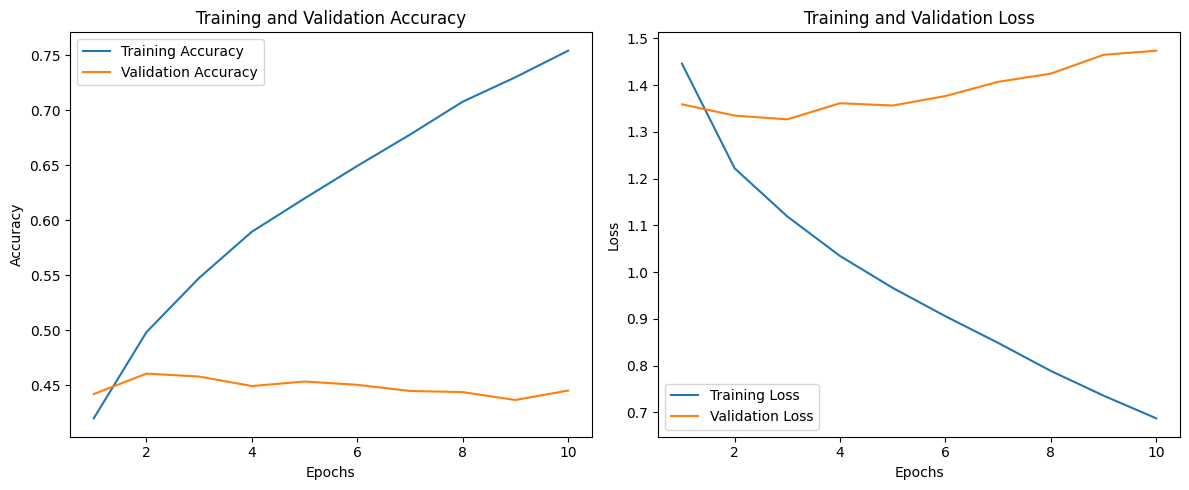

In [43]:
evaluate_and_plot(xception_history)

## MobileNet

In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules
import numpy as np

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")


inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)

outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project"
model_name = 'best_mobilenet_model_baseline_.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Visual reg/Project"
model_name = 'best_mobilenet_model_baseline_.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

mobilenet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]

evaluate_and_plot(mobilenet_history)

# 6a. Multitask Learning

In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import numpy as np

# Create lists
images, ages, races, genders = create_lists(df[df['dataset'] == 'FairFace'])

# 7. Only FairFace

In [ ]:
import_packages()

# Create lists
images, ages, races, genders = create_lists(df[df['dataset'] == 'FairFace'])

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Reduce sample size
images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
    images_preprocessed, ages, races, genders, test_size=0.50, random_state=42, stratify=ages
)

# First, split the data into training (75%) and temporary set (25%) which will be split into validation and test
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
    images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample
)

# Now split the temporary set into validation (20% of total) and test (5% of total)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age
)

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Define model
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = "/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project"
model_name = 'best_mobilenet_model_baseline_fairface.keras'
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

mobilenet_fairface_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

evaluate_and_plot(mobilenet_fairface_history)

Epoch 1/30
1145/1145 [==============================] - ETA: 0s - loss: 1.5177 - accuracy: 0.3806
Epoch 1: val_accuracy improved from -inf to 0.42139, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Projectbest_mobilenet_model_baseline_fairface.keras
1145/1145 [==============================] - 210s 180ms/step - loss: 1.5177 - accuracy: 0.3806 - val_loss: 1.4055 - val_accuracy: 0.4214
Epoch 2/30
1145/1145 [==============================] - ETA: 0s - loss: 1.2681 - accuracy: 0.4766
Epoch 2: val_accuracy improved from 0.42139 to 0.43316, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Projectbest_mobilenet_model_baseline_fairface.keras
1145/1145 [==============================] - 200s 174ms/step - loss: 1.2681 - accuracy: 0.4766 - val_loss: 1.3653 - val_accuracy: 0.4332
Epoch 3/30
1145/1145 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.5295
Epoch 3: val_accuracy improved from 0.43316 to 0.44350, saving model to /co